In [1]:
import warnings
import itertools
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Bidirectional, GRU
#from keras.layers.recurrent import LSTM
from sklearn.utils import shuffle
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
py.init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')


In [2]:
# Datayı Yükleyelim
data = pd.read_excel(r"C:\Users\Ali\Desktop\EVDS.xlsx", date_parser=[0])
# İlk 5 Satır
data.head()

,Tarih,TP MK CUM YTL
0,2010-09,416.33
1,2010-10,417.75
2,2010-11,424.00
3,2010-12,461.00
4,2011-01,465.75


In [3]:
data.columns


Index(['Tarih', 'TP MK CUM YTL'], dtype='object')

In [4]:
data = data.rename(columns={'Tarih': 'tarih'})
data = data.rename(columns={'TP MK CUM YTL': 'altın'})

In [5]:
#Datetime Haline Getirilmesi
data['tarih'] = pd.to_datetime(data.tarih, format='%Y-%m')
#İndex'e Alınması
data.index = data.tarih

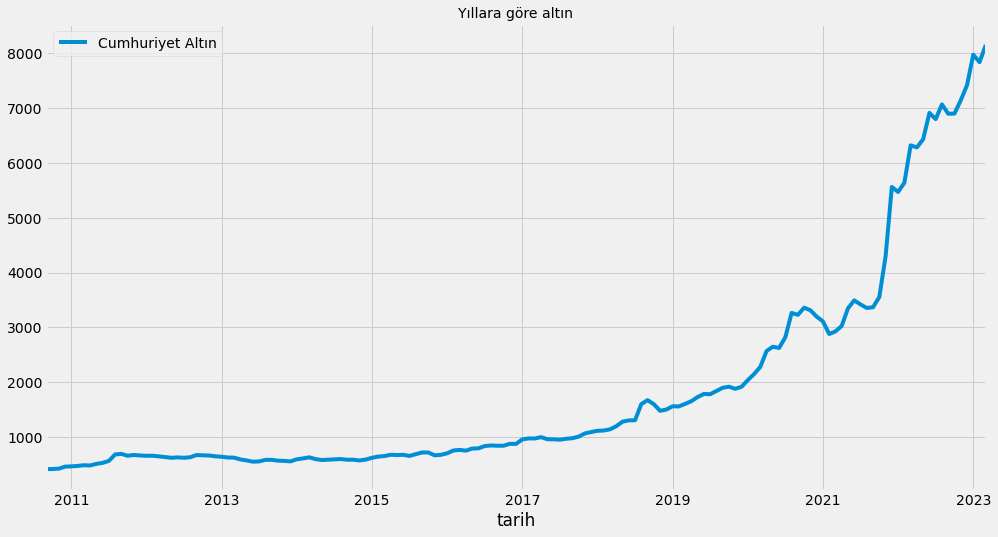

In [6]:
fig = plt.figure(figsize=(15,8))
data.altın.plot(label='Cumhuriyet Altın')
plt.legend(loc='best')
plt.title('Yıllara göre altın', fontsize=14)
plt.show()

In [7]:
values = data['altın'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)
# Birkaç Değere Bakalım
dataset[0:5]

array([[0.        ],
       [0.00018365],
       [0.00099197],
       [0.00577724],
       [0.00639156]], dtype=float32)

In [8]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Ay Sayıları (training set, test set): " + str((len(train), len(test))))

Ay Sayıları (training set, test set): (90, 61)


In [9]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [10]:
# Verisetlerimizi Oluşturalım
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Yeni verisetinin şekline bakalım.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(88, 1)
New training data shape:
(88, 1, 1)


In [11]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    # Modelin tek layerlı şekilde kurulacak.
    model.add(LSTM(100, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
   #30 epoch yani 30 kere verisetine bakılacak.
    model.fit(train_X, 
              train_Y, 
              epochs = 30, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/30
88/88 [==============================] - 1s 1ms/step - loss: 4.8728e-04
Epoch 2/30
88/88 [==============================] - 0s 1ms/step - loss: 3.3846e-04
Epoch 3/30
88/88 [==============================] - 0s 1ms/step - loss: 2.9876e-04
Epoch 4/30
88/88 [==============================] - 0s 1ms/step - loss: 2.0130e-04
Epoch 5/30
88/88 [==============================] - 0s 1ms/step - loss: 1.4617e-04
Epoch 6/30
88/88 [==============================] - 0s 1ms/step - loss: 8.0182e-05
Epoch 7/30
88/88 [==============================] - 0s 1ms/step - loss: 4.2217e-05
Epoch 8/30
88/88 [==============================] - 0s 1ms/step - loss: 2.1378e-05
Epoch 9/30
88/88 [==============================] - 0s 1ms/step - loss: 1.6339e-05
Epoch 10/30
88/88 [==============================] - 0s 1ms/step - loss: 1.4346e-05
Epoch 11/30
88/88 [==============================] - 0s 1ms/step - loss: 1.7363e-05
Epoch 12/30
88/88 [==============================] - 0s 1ms/step - loss: 1.3322e-05
E

In [12]:
def predict_and_score(model, X, Y):
    # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    # Rmse değerlerini ölçüyoruz.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

2/2 [==============================] - 0s 2ms/step
Training data score: 26.85 RMSE
Test data score: 302.79 RMSE


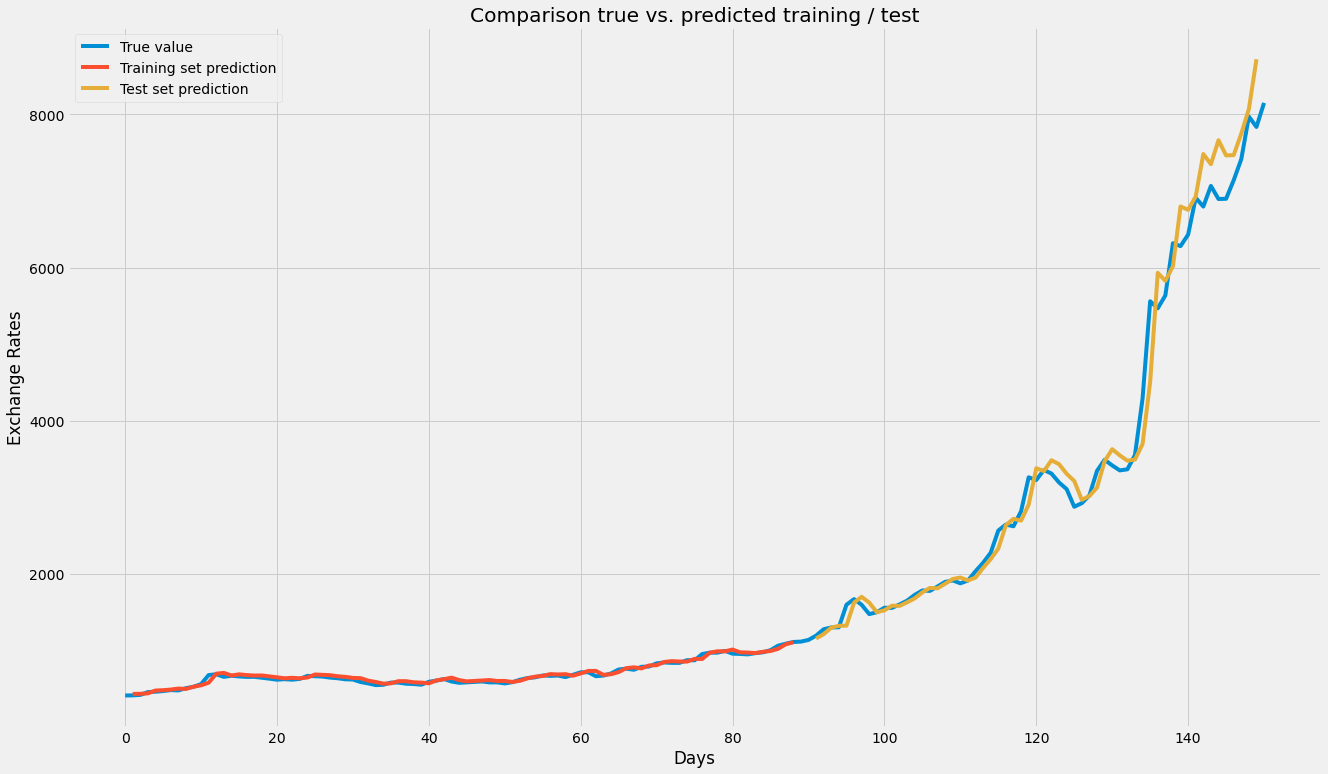

In [13]:
# Öğrendiklerinini tahminletip ekliyoruz.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Şimdi ise testleri tahminletiyoruz.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Plot'u oluşturalım.
plt.figure(figsize = (20, 12))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Exchange Rates")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

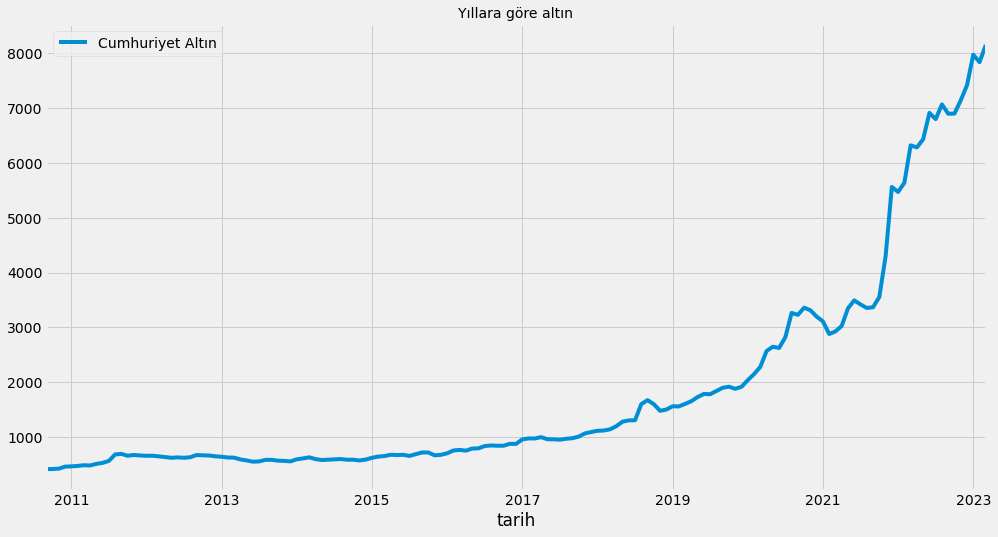

In [37]:
fig = plt.figure(figsize=(15,8))
data.altın.plot(label='Cumhuriyet Altın')
plt.legend(loc='best')
plt.title('Yıllara göre altın', fontsize=14)
plt.show()